In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import transforms as T

import os
cwd=os.getcwd()
os.chdir(cwd[:len('StableRemaster')+cwd.find('StableRemaster')])

from tqdm import tqdm

In [2]:
from src import *

In [3]:
DATA_PATH = './data/02_scenes/'

In [66]:
ls = [1,2,3,4]
ls[0:-1]

[1, 2, 3]

In [166]:
def display_masked_image(im, mask):
    new_im = cv2.bitwise_and(im , im , mask = mask)
    plt.imshow(new_im)

def trim_black(frame,mask):
    #print(frame.shape)
    if not np.any(frame):
        print('fuck')
        return frame,mask
    
    it_bottom = -1
    while not(np.any(frame[it_bottom,:,:])):
        it_bottom-=1
    
    it_top = 0
    while not(np.any(frame[it_top,:,:])):
        it_bottom+=1
    
    it_right = -1
    while not(np.any(frame[:,it_right,:])):
        it_right-=1
    
    it_left = 0
    while not(np.any(frame[:,it_left,:])):
        it_left+=1
    
    it_bottom = frame.shape[0]+it_bottom+1
    it_right = frame.shape[1]+it_right+1
    
    frame = frame[it_top:it_bottom,it_left:it_right,:]
    mask = mask[it_top:it_bottom,it_left:it_right]
    
    return frame,mask
    
def get_padding(x_offset,y_offset):
    y=int(np.floor(abs(y_offset)))
    x=int(np.floor(abs(x_offset)))
    
    x_pad=None
    y_pad=None
    
    if x_offset<=0:
        x_pad = (0,x)
    else:
        x_pad = (x,0)
    if y_offset<=0:
        y_pad = (0,y)
    else:
        y_pad = (y,0)

    return x_pad,y_pad
    
def stitch_images(image1, image2, mask1, mask2, scale=1):
    # Detect features and keypoints using SIFT
    sift = cv2.SIFT_create()
    #display_masked_image(image1,mask1)
    keypoints1, descriptors1 = sift.detectAndCompute(image1, mask1)
    keypoints2, descriptors2 = sift.detectAndCompute(image2, mask2)

    # Match the features using FLANN-based matcher
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    # Filter good matches using the ratio test
    good_matches = []
    for pair in matches:
        if len(pair) == 2:
            m, n = pair
            if m.distance < 0.5 * n.distance:
                good_matches.append(m)

    if len(good_matches) < 10:  # Minimum number of matches required for homography
        print("Not enough good matches found to stitch the images.")
        return image1, mask1

    # Extract the matched points
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Compute the homography using RANSAC
    H, _ = cv2.estimateAffine2D(src_pts, dst_pts, cv2.RANSAC)
    
    x_offset = H[0,2]
    y_offset = H[1,2]
    
    if(abs(x_offset)>1 or abs(y_offset)>1):
        print(y_offset,x_offset)
    
    # Warp image2 using the computed homography
    h, w = image1.shape[:2]
    
    #h += int(np.floor(abs(y_offset)))
    #w += int(np.floor(abs(x_offset)))
    #h = image1.shape[0]+image2.shape[0]
    #w = image1.shape[1]+image2.shape[1]
    warped_image2 = cv2.warpAffine(image2, H, (w, h))
    warped_mask = cv2.warpAffine(mask2,H, (w,h))
    
    #return H, warped_image2
    #return image2,warped_image2
    #x_pad, y_pad = get_padding(x_offset,y_offset)
    
    #padded_image1 = np.pad(image1, (y_pad,x_pad,(0,0)),'constant',constant_values=(0,0))
    #padded_mask1 = np.pad(mask1, (y_pad,x_pad),'constant',constant_values=(0,0))
    
    #print(padded_mask1.shape,warped_mask.shape)
    stitched_mask = np.any([mask1,warped_mask],axis=0).astype('uint8')
    #stitched_mask = np.any([padded_mask1,warped_mask],axis=0).astype('uint8')
    
    #masked_im1 = cv2.bitwise_and(padded_image1 , padded_image1 , mask = padded_mask1).astype('uint8')
    #masked_im2 = cv2.bitwise_and(warped_image2 , warped_image2 , mask = warped_mask).astype('uint8')
    masked_im1 = cv2.bitwise_and(image1 , image1 , mask = mask1).astype('uint8')
    masked_im2 = cv2.bitwise_and(warped_image2 , warped_image2 , mask = warped_mask).astype('uint8')
    
    warped_mask = warped_mask/scale
    masked_im2 = masked_im2/scale
    
    #mask_count = np.sum([padded_mask1,warped_mask],axis=0)
    mask_count = np.sum([mask1,warped_mask],axis=0)
    mask_count[np.where(mask_count==0)]=1
    im_sum = np.sum([masked_im1,masked_im2],axis=0)
    
    averaged_image = (im_sum/np.expand_dims(mask_count, axis=-1)).astype('uint8')
    
    return averaged_image, stitched_mask


def stitch_multiple(images, masks):
    if len(images) < 2:
        raise ValueError("At least two images are required for stitching.")

    stitched_image = images[0]
    stitched_mask = masks[0]
    
    for i in tqdm(range(1, len(images))):
        stitched_image, stitched_mask = stitch_images(stitched_image, images[i], stitched_mask, masks[i],scale=i)
        #print(stitched_image.shape)
        stitched_image, stitched_mask = trim_black(stitched_image, stitched_mask)
        #print(stitched_image.shape)
    return stitched_image,stitched_mask

In [5]:
cap_path = f'{DATA_PATH}atla_s1e1-Scene-151.mp4'
frames = split_video(cap_path)

In [6]:
segmenter = background_segmentation_loader()

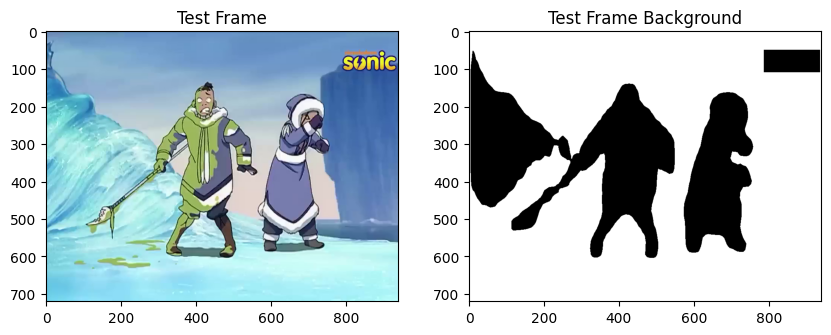

In [7]:
test_frame1 = frames[0]

bg1,bg_mask1 = segmenter(test_frame1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(test_frame1, cmap='gray')
ax1.set_title('Test Frame')

ax2.imshow(bg_mask1, cmap='gray')
ax2.set_title('Test Frame Background')

# show the figure
plt.show()

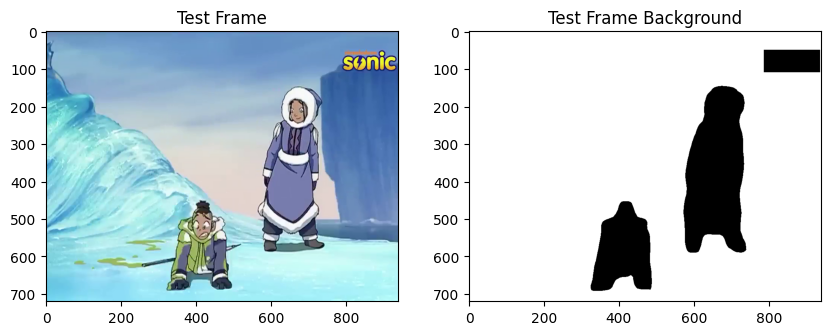

In [183]:
test_frame2 = frames[70]

bg2, bg_mask2 = segmenter(test_frame2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(test_frame2, cmap='gray')
ax1.set_title('Test Frame')

ax2.imshow(bg_mask2, cmap='gray')
ax2.set_title('Test Frame Background')

# show the figure
plt.show()

In [184]:
stitched_im, stitched_mask = stitch_images(test_frame1, test_frame2, bg_mask1, bg_mask2)

In [174]:
t1,t2=trim_black(stitched_mask,stitched_mask)

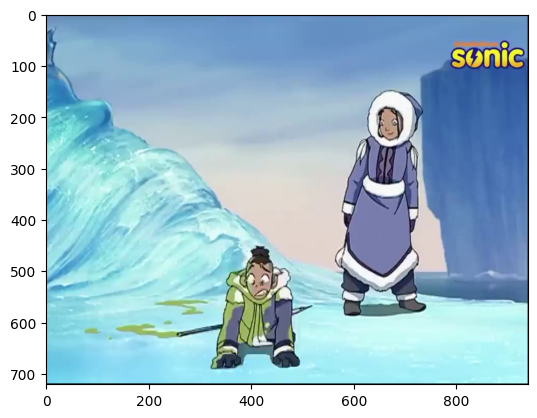

In [175]:
plt.imshow(t1)

In [135]:
test_frame2.shape

(720, 940, 3)

In [145]:
temp1 = np.roll(test_frame2,1,axis=1)

In [150]:
temp=(test_frame2-test_frame2)

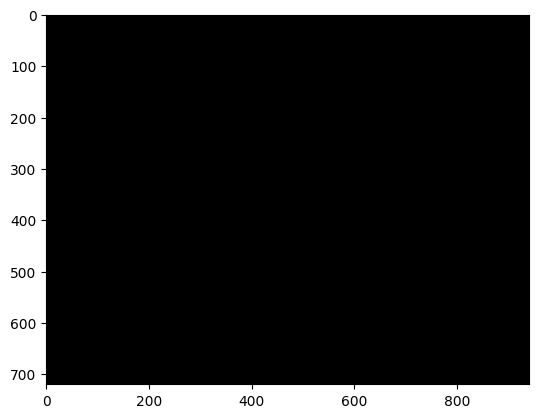

In [151]:
plt.imshow(temp,'gray')

In [18]:
masks = []
bgs = []
for frame in tqdm(frames):
    bg, bg_mask = segmenter(frame,mask_conf=0.2,cat_conf=0.4)
    masks.append(bg_mask)
    bgs.append(bg)

100%|█████████████████████████████████████████| 132/132 [06:01<00:00,  2.74s/it]


In [165]:
total_bg, total_mask = stitch_multiple(frames, masks)

 54%|██████████████████████▊                   | 71/131 [00:19<00:15,  3.78it/s]

-1.1195297225324334 0.853418201809049


 55%|███████████████████████                   | 72/131 [00:19<00:15,  3.79it/s]

-1.0019707365923654 0.8821770517048435


 60%|█████████████████████████                 | 78/131 [00:21<00:13,  3.89it/s]

-0.7469580048505904 1.7664792498761326


 63%|██████████████████████████▌               | 83/131 [00:22<00:12,  3.80it/s]

-0.7015221093635323 1.6437402461468125


 97%|███████████████████████████████████████▋ | 127/131 [00:34<00:01,  3.89it/s]

-1.2346212269717824 1.1620499166588614


100%|█████████████████████████████████████████| 131/131 [00:35<00:00,  3.73it/s]


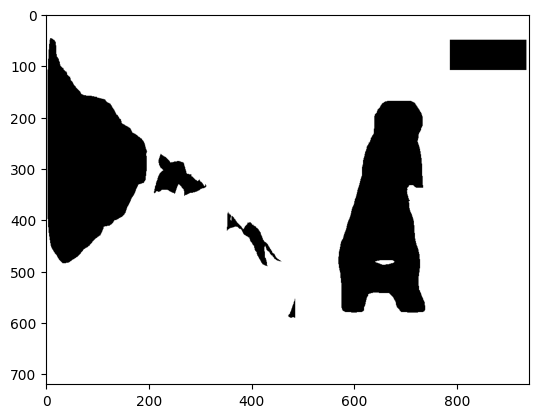

In [163]:
plt.imshow(total_mask,'gray')

In [119]:
def get_new_window_mask(frame_shape):
    new_width = frame_shape[0]*16//9
    new_window_mask = np.ones((frame_shape[0],new_width))
    left_bar = (new_width-test_frame1.shape[1])//2
    right_bar = new_width-left_bar
    new_window_mask[:,left_bar:right_bar]=0
    return new_window_mask

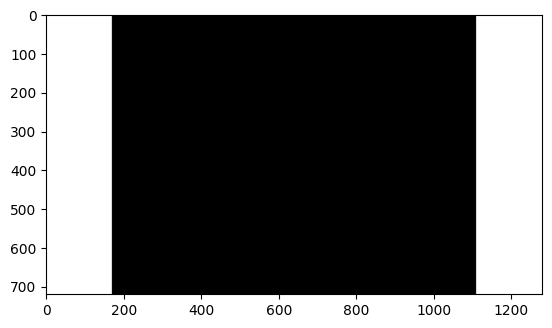

In [120]:
new_window_mask=get_new_window_mask(test_frame1.shape)
plt.imshow(new_window_mask,'gray')